<a href="https://colab.research.google.com/github/dugaryash/Categorization-of-various-Planktons/blob/main/Plankton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c datasciencebowl
!kaggle config set -n iterativestratification

In [ ]:
! unzip train.zip
! unzip test.zip
! unzip sampleSubmission.csv.zip


In [4]:
# Addition of necessary Libraries for code execution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import torch
import torch.nn as nn

from glob import glob
from warnings import filterwarnings
filterwarnings('ignore')
from termcolor import cprint
from PIL import Image
from torchvision import transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
# Keeping the seed constant to get a fix output result

torch.manual_seed(786)
np.random.seed(786)
random.seed(786)

In [13]:
# Neural Network blocks and models

class CNN(nn.Module):
    def __init__(self, channel_in, channel_out, kerel_size = 3, stride = 1, padding = 0):
        super(CNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(channel_in, channel_out, kerel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(channel_out),
        )
    def forward(self, x):
        return self.seq(x)

class PNet(nn.Module):
    def __init__(self, channel_in, num_classes, H = 128, W = 128):
        super(PNet, self).__init__()
        self.model = nn.Sequential(
            CNN(channel_in, 16, 4), #125
            nn.MaxPool2d(2), #62
            CNN(16, 32, 3), #60
            CNN(32, 64, 3), #58
            nn.Dropout(0.1),
            nn.MaxPool2d(2), # 29
            CNN(64, 128), # 27
            nn.Dropout(0.2),
            CNN(128, 64, 3), # 25
            CNN(64, 32, 3), # 23
            nn.Flatten(),
            nn.Linear(32*23*23 , 4096),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        return self.model(x)

Category = []
Category_count = []

for name in os.listdir('./train/'):
    Category.append(name)
    Category_count.append(len(os.listdir(f'./train/{name}')))

Category_num = len(Category)
model = PNet(3, Category_num, 128, 128)

In [14]:
data_random = torch.rand(1, 3, 128, 128)
print(model(data_random).shape)

torch.Size([1, 121])


In [15]:
cprint(model, "green")

PNet(
  (model): Sequential(
    (0): CNN(
      (seq): Sequential(
        (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNN(
      (seq): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): CNN(
      (seq): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Dropout(p=0.1, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): CNN(
      (seq): Sequential(
        (0): Conv2d(64, 128, kernel_siz

In [16]:
# Model layers overview

for name, x in model.named_parameters():
    print(f"{name} : {x.shape}")

model.0.seq.0.weight : torch.Size([16, 3, 4, 4])
model.0.seq.0.bias : torch.Size([16])
model.0.seq.2.weight : torch.Size([16])
model.0.seq.2.bias : torch.Size([16])
model.2.seq.0.weight : torch.Size([32, 16, 3, 3])
model.2.seq.0.bias : torch.Size([32])
model.2.seq.2.weight : torch.Size([32])
model.2.seq.2.bias : torch.Size([32])
model.3.seq.0.weight : torch.Size([64, 32, 3, 3])
model.3.seq.0.bias : torch.Size([64])
model.3.seq.2.weight : torch.Size([64])
model.3.seq.2.bias : torch.Size([64])
model.6.seq.0.weight : torch.Size([128, 64, 3, 3])
model.6.seq.0.bias : torch.Size([128])
model.6.seq.2.weight : torch.Size([128])
model.6.seq.2.bias : torch.Size([128])
model.8.seq.0.weight : torch.Size([64, 128, 3, 3])
model.8.seq.0.bias : torch.Size([64])
model.8.seq.2.weight : torch.Size([64])
model.8.seq.2.bias : torch.Size([64])
model.9.seq.0.weight : torch.Size([32, 64, 3, 3])
model.9.seq.0.bias : torch.Size([32])
model.9.seq.2.weight : torch.Size([32])
model.9.seq.2.bias : torch.Size([32])


In [17]:
def generate_csv(root,train = True, img_ext = 'jpg'):
    df = pd.DataFrame(columns = ['path', 'class'])
    if train:
        for index,label in enumerate(os.listdir(root)):
            links = glob(f"{root}/{label}/*{img_ext}")
            temp_df = pd.DataFrame({'path': links, 'class': np.ones(len(links), dtype='float32')*index})
            df = pd.concat([df, temp_df], axis = 0)
    else:
        links = glob(f"{root}/*{img_ext}")
        temp_df = pd.DataFrame({'path': links, 'class': np.ones(len(links), dtype = 'float32')})
        df = pd.concat([df, temp_df], axis = 0)
        
    return df

In [18]:
train_csv = generate_csv('./train')
train_csv.head()

,path,class
0,./train/appendicularian_s_shape/118474.jpg,0.0
1,./train/appendicularian_s_shape/141457.jpg,0.0
2,./train/appendicularian_s_shape/159479.jpg,0.0
3,./train/appendicularian_s_shape/149275.jpg,0.0
4,./train/appendicularian_s_shape/80945.jpg,0.0


In [19]:
test_csv = generate_csv('./test',train = False)
test_csv.head()

,path,class
0,./test/111569.jpg,1.0
1,./test/146876.jpg,1.0
2,./test/124340.jpg,1.0
3,./test/18907.jpg,1.0
4,./test/22331.jpg,1.0


In [20]:
# Sorting images based on their names

test_csv.sort_values('path', inplace = True)
test_csv.head()

,path,class
71897,./test/1.jpg,1.0
122829,./test/10.jpg,1.0
86877,./test/100.jpg,1.0
30332,./test/1000.jpg,1.0
4763,./test/10000.jpg,1.0


In [21]:
# building up the dataset classes

def load_image(path , H, W):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (H,W))
    return img

def transform():
    return transforms.Compose([
        transforms.RandomRotation(90),
        transforms.ToTensor()
    ])


class PlanktonDataset(Dataset):
    def __init__(self, df, H = 128, W = 128, transform = None):
        super(PlanktonDataset, self).__init__()
        self.df = df
        self.H = H
        self.W = W
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        path = self.df.iloc[index, 0]
        img = load_image(path, H = self.H, W = self.W)
        label = self.df.iloc[index, 1]
        img = Image.fromarray(img)
        if self.transform != None:
            img = self.transform()(img)
        else:
            img = transforms.ToTensor()(img)
        return (img, (label, path))
    
# Creating the train and test datasets.   
train_ds = PlanktonDataset(train_csv, 128, 128, transform = transform)
test_ds = PlanktonDataset(test_csv, 128, 128)

In [22]:
# data access format

image, label = test_ds.__getitem__(3)
image.shape, label[0], label[1]

(torch.Size([3, 128, 128]), 1.0, './test/1000.jpg')

In [23]:
# Train-Validation Split :

spl_idx = int(train_ds.__len__() * 0.8)
print(f"Splitting index : {spl_idx}")
train_ds, val_ds = torch.utils.data.random_split(train_ds,[spl_idx, train_ds.__len__() - spl_idx] )

Splitting index : 24268


In [24]:
print(f"Size of train dataset : {train_ds.__len__()}")
print(f"Size of validation dataset : {val_ds.__len__()}")
print(f"Size of test dataset : {test_ds.__len__()}")

Size of train dataset : 24268
Size of validation dataset : 6068
Size of test dataset : 130400


In [25]:
# Creating data loaders specifying the batch size

BATCH_SIZE = 32
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_dl = DataLoader(val_ds, batch_size = BATCH_SIZE, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

In [26]:
# Chossing training hyperparameters and also the optimizer and loss

EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params = model.parameters(), lr = 1e-4)

In [27]:
train_loss = []
val_loss = []

In [28]:
# Model Training...
model = model.cuda()
best_loss = np.inf
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} : \n")
    TR_LOSS = 0.0
    VAL_LOSS = 0.0
    model.train()
    
    # Train Data Forward & Backward Pass
    
    for index, (train_patch, (labels, _)) in enumerate(train_dl):
        optim.zero_grad()
        train_patch = train_patch.cuda()
        labels = labels.long().cuda()
        op = model(train_patch)
        tloss = criterion(op, labels)
        TR_LOSS += tloss.item()
        train_loss.append(tloss.item())
        tloss.backward()
        optim.step()
        
        if index % 100 == 99:
            print(f"         Step {index + 1} Loss : {'%.4f'%(tloss.item())}")   
    model.eval()
    
    # Validation Checking ( Only Forward Pass )
    
    with torch.no_grad():
        for index, (val_patch, (labels, _)) in enumerate(val_dl):
            val_patch = val_patch.cuda()
            labels = labels.long().cuda()
            op = model(val_patch)
            vloss = criterion(op, labels)
            VAL_LOSS += vloss.item()
            val_loss.append(vloss.item())
    print(f"\n     Training Loss : {'%.4f'%(TR_LOSS)}  ||  Validation Loss : {'%.4f'%(VAL_LOSS)}\n")
    
    if VAL_LOSS < best_loss :      # Model Updationg
        cprint("Model Updation : Success!\n", 'green')
        torch.save(model, 'best_model.pth')
        best_loss = VAL_LOSS
    else:
        cprint("Model Updation : Failed!\n", 'red')
cprint('Training completed...', 'green')

Epoch 1 : 

         Step 100 Loss : 2.6842
         Step 200 Loss : 2.7298
         Step 300 Loss : 3.1623
         Step 400 Loss : 2.1274
         Step 500 Loss : 2.9176
         Step 600 Loss : 3.3919
         Step 700 Loss : 2.4912

     Training Loss : 2092.2597  ||  Validation Loss : 1252.2499

Model Updation : Success!

Epoch 2 : 

         Step 100 Loss : 2.1464
         Step 200 Loss : 2.1556
         Step 300 Loss : 2.4642
         Step 400 Loss : 2.7846
         Step 500 Loss : 2.3731
         Step 600 Loss : 2.0237
         Step 700 Loss : 1.9218

     Training Loss : 1700.7485  ||  Validation Loss : 554.0249

Model Updation : Success!

Epoch 3 : 

         Step 100 Loss : 1.6344
         Step 200 Loss : 1.9798
         Step 300 Loss : 2.0943
         Step 400 Loss : 1.9143
         Step 500 Loss : 1.7770
         Step 600 Loss : 2.2272
         Step 700 Loss : 2.0047

     Training Loss : 1501.9614  ||  Validation Loss : 1397.2450

Model Updation : Failed!

Epoch 4 : 

   

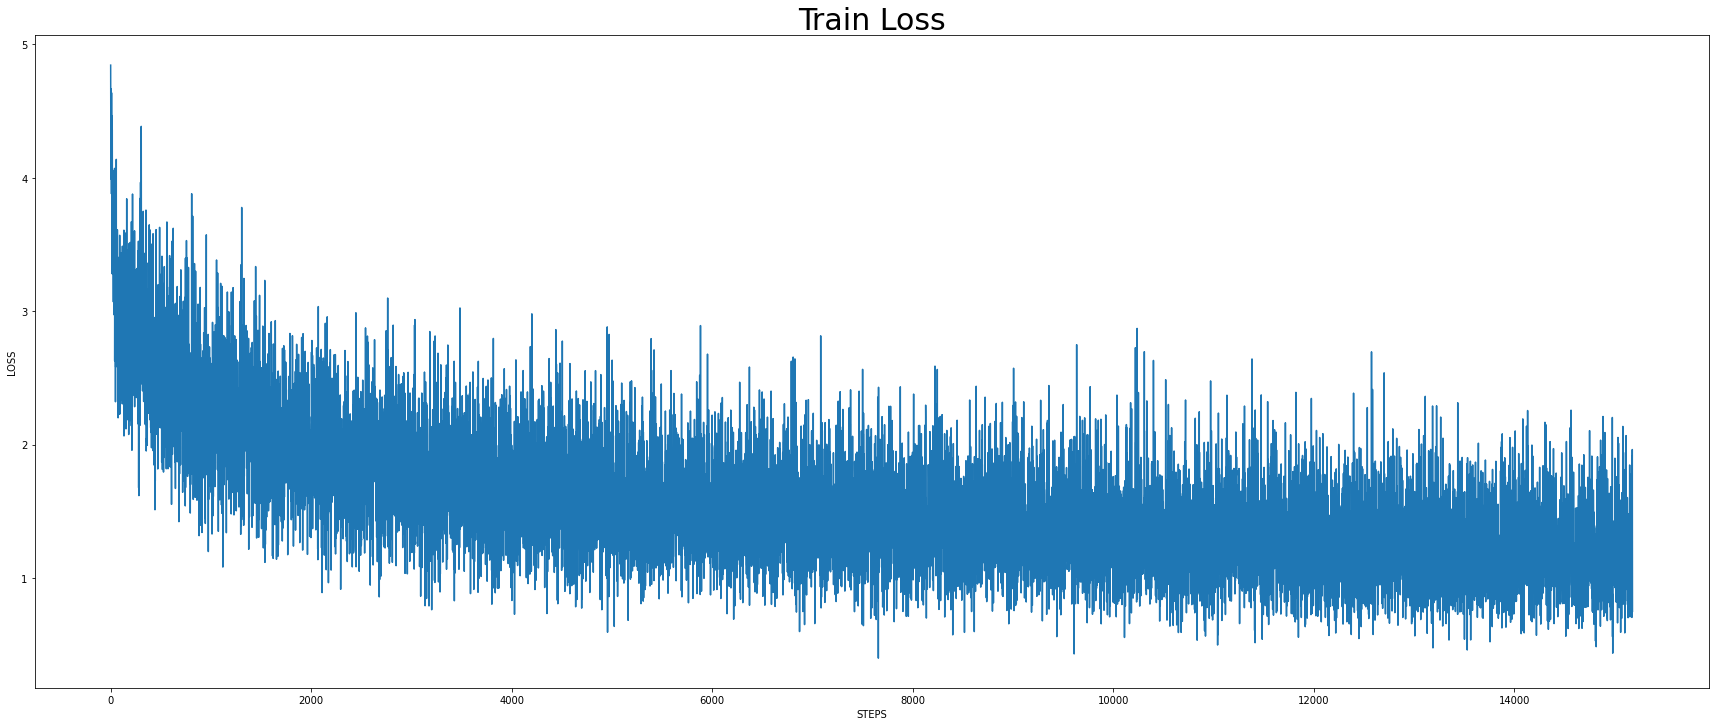

In [31]:
plt.figure(figsize=(30,12))
plt.plot(train_loss)
plt.title('Train Loss', size = 30)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

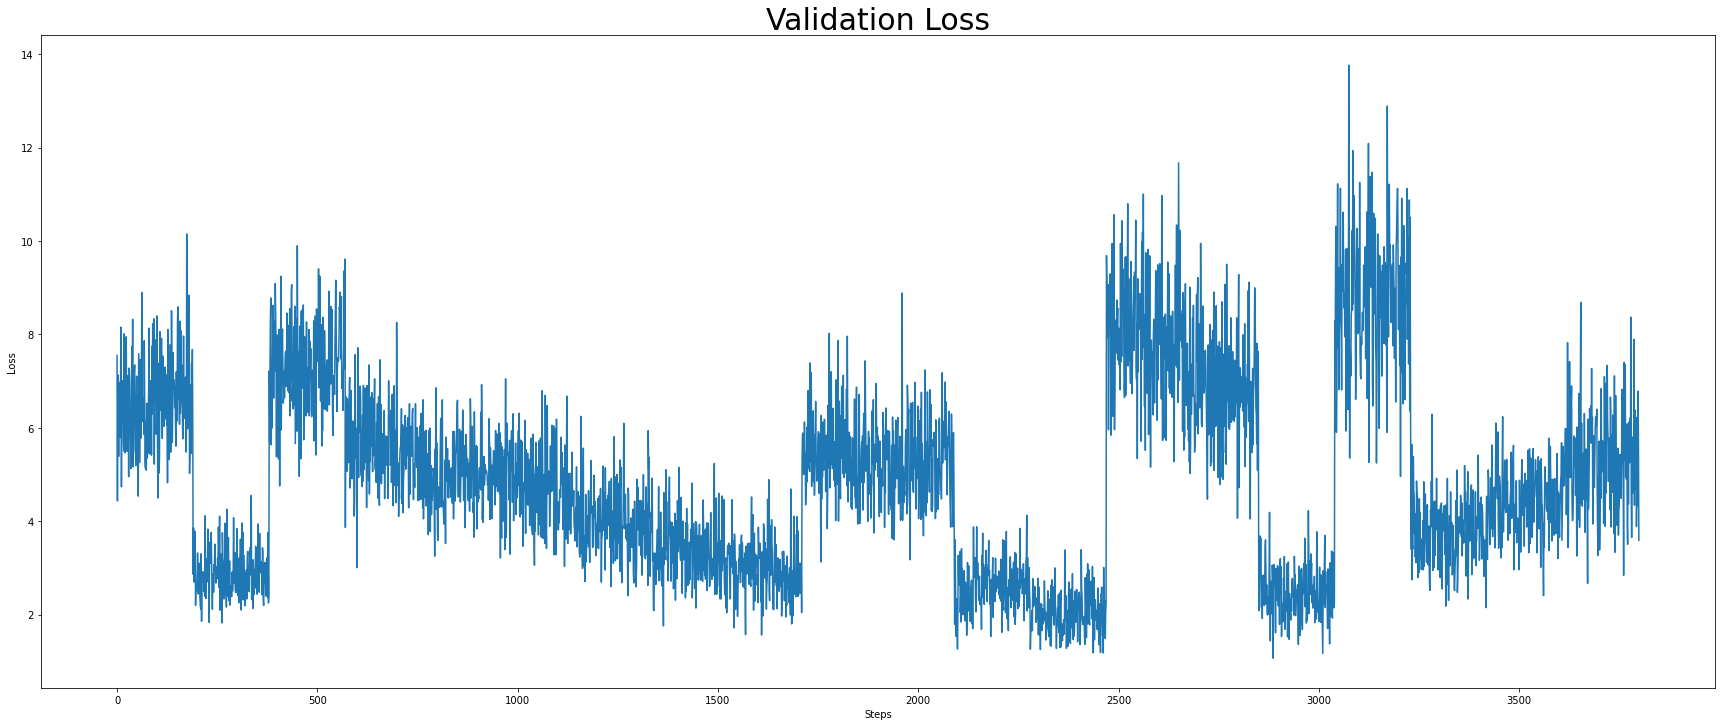

In [32]:
plt.figure(figsize=(30,12))
plt.plot(val_loss)
plt.title('Validation Loss', size = 30)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

In [33]:
best_model = torch.load('./best_model.pth')
cprint(best_model, 'green')

PNet(
  (model): Sequential(
    (0): CNN(
      (seq): Sequential(
        (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNN(
      (seq): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): CNN(
      (seq): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Dropout(p=0.1, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): CNN(
      (seq): Sequential(
        (0): Conv2d(64, 128, kernel_siz

In [34]:
# Now we will filter the names of the different

def preprocess_names(names_list):
    name_list = []
    for name in names_list:
        name_list.append(name.split('/')[-1])
    return name_list

In [35]:
# Generating function for test data

def create_submission_file(test_dataloader, model, class_names):
    df = pd.DataFrame()
    model.eval()
    sf_layer = nn.Softmax(dim = 1)
    with torch.no_grad():
        for index, (test_patch, attr) in enumerate(test_dataloader):  # loading test data
            paths = preprocess_names(attr[1])
            test_patch = test_patch.cuda()
            op = model(test_patch)
            op = sf_layer(op)
            paths = np.array(list(paths))   #adding the filenames in a list
            op = op.cpu().detach().numpy()
            patch_df = pd.DataFrame(op, columns = class_names)  #creating the patch dataframe
            patch_df.insert(0, 'image', paths)
            df = pd.concat([df, patch_df], axis = 0)    # joining the patch dataframe with the main one.
            
            if index % 100 == 99:
                print(f"{index + 1} Steps Completed...\n")    
    print('Test Dataframe Generated...\n')
    
    return df

In [37]:
best_model = best_model.cuda()
pred_df = create_submission_file(test_dl, best_model, Category)
pred_df.head()

100 Steps Completed...

200 Steps Completed...

300 Steps Completed...

400 Steps Completed...

500 Steps Completed...

600 Steps Completed...

700 Steps Completed...

800 Steps Completed...

900 Steps Completed...

1000 Steps Completed...

1100 Steps Completed...

1200 Steps Completed...

1300 Steps Completed...

1400 Steps Completed...

1500 Steps Completed...

1600 Steps Completed...

1700 Steps Completed...

1800 Steps Completed...

1900 Steps Completed...

2000 Steps Completed...

2100 Steps Completed...

2200 Steps Completed...

2300 Steps Completed...

2400 Steps Completed...

2500 Steps Completed...

2600 Steps Completed...

2700 Steps Completed...

2800 Steps Completed...

2900 Steps Completed...

3000 Steps Completed...

3100 Steps Completed...

3200 Steps Completed...

3300 Steps Completed...

3400 Steps Completed...

3500 Steps Completed...

3600 Steps Completed...

3700 Steps Completed...

3800 Steps Completed...

3900 Steps Completed...

4000 Steps Completed...

Test Data

,image,appendicularian_s_shape,hydromedusae_typeD_bell_and_tentacles,chaetognath_non_sagitta,hydromedusae_haliscera_small_sideview,detritus_other,echinoderm_seacucumber_auricularia_larva,detritus_blob,jellies_tentacles,hydromedusae_shapeA,ctenophore_cestid,diatom_chain_tube,echinoderm_larva_pluteus_early,tunicate_partial,acantharia_protist,euphausiids_young,copepod_other,fish_larvae_thin_body,protist_dark_center,copepod_calanoid,trichodesmium_multiple,artifacts,protist_fuzzy_olive,shrimp_caridean,heteropod,protist_noctiluca,hydromedusae_narco_young,invertebrate_larvae_other_B,hydromedusae_h15,siphonophore_calycophoran_sphaeronectes,ctenophore_cydippid_tentacles,protist_star,appendicularian_slight_curve,copepod_calanoid_large,unknown_unclassified,polychaete,shrimp_zoea,fish_larvae_deep_body,echinopluteus,hydromedusae_haliscera,...,siphonophore_partial,hydromedusae_liriope,copepod_cyclopoid_oithona_eggs,hydromedusae_shapeA_sideview_small,copepod_calanoid_large_side_antennatucked,pteropod_theco_dev_seq,siphonophore_calycophoran_abylidae,trichodesmium_puff,tunicate_doliolid_nurse,stomatopod,acantharia_protist_halo,ephyra,siphonophore_calycophoran_rocketship_young,appendicularian_straight,hydromedusae_other,hydromedusae_typeE,hydromedusae_sideview_big,shrimp-like_other,hydromedusae_typeF,siphonophore_physonect,ctenophore_lobate,ctenophore_cydippid_no_tentacles,siphonophore_calycophoran_sphaeronectes_stem,chaetognath_sagitta,decapods,acantharia_protist_big_center,copepod_cyclopoid_copilia,chordate_type1,pteropod_triangle,protist_other,siphonophore_calycophoran_sphaeronectes_young,echinoderm_larva_seastar_brachiolaria,copepod_calanoid_eucalanus,pteropod_butterfly,hydromedusae_narco_dark,unknown_blobs_and_smudges,fish_larvae_very_thin_body,chaetognath_other,copepod_calanoid_flatheads,siphonophore_physonect_young
0,1.jpg,6.517215e-04,4.280552e-11,1.934714e-05,1.844693e-09,2.628670e-03,5.173606e-06,6.576722e-04,6.305602e-06,2.200611e-09,1.461978e-06,8.324292e-02,1.455968e-03,5.177550e-08,1.399636e-06,2.250133e-06,1.395397e-04,1.842706e-04,7.167879e-07,8.354036e-04,3.336603e-08,3.545043e-03,7.356903e-06,1.536216e-06,7.402260e-08,2.472725e-04,1.527593e-05,4.074615e-05,2.032305e-06,8.493761e-06,2.065729e-06,9.136981e-04,3.425550e-05,1.322536e-04,9.597256e-05,2.287717e-07,3.211451e-05,1.010626e-05,2.216509e-05,6.694650e-07,...,2.637260e-09,1.829441e-08,5.349189e-06,7.120870e-06,1.594882e-03,6.423135e-06,6.189109e-06,5.608848e-06,3.636941e-07,6.299846e-07,2.676284e-08,3.132193e-06,5.138302e-04,3.110464e-04,3.682382e-07,3.186980e-08,6.293901e-09,1.620772e-04,3.418605e-04,8.129326e-10,1.119388e-07,6.003057e-06,2.402994e-05,5.852875e-07,2.447093e-05,2.413162e-09,6.244367e-07,4.357383e-04,4.738687e-05,1.563095e-03,6.096880e-05,1.507969e-05,4.712537e-06,7.688755e-06,1.013734e-05,8.279181e-02,2.216733e-05,4.953415e-04,1.022758e-04,8.211402e-07
1,10.jpg,6.077425e-07,2.080321e-11,6.676249e-07,9.998130e-11,6.935382e-04,2.455155e-07,8.911394e-05,5.852200e-07,2.433992e-09,9.157850e-09,1.823217e-05,1.152123e-03,2.237197e-09,3.289237e-06,1.010941e-06,1.490311e-05,2.828286e-06,3.599688e-07,4.387012e-02,2.134917e-08,1.745366e-04,1.565668e-06,8.138783e-06,1.225863e-08,3.968507e-05,1.395980e-07,3.454074e-06,2.267005e-08,6.582378e-09,8.524199e-08,1.695382e-06,1.379551e-07,4.476169e-03,1.176387e-05,7.003391e-09,3.446166e-05,2.551018e-07,1.680113e-07,3.467318e-10,...,5.814609e-11,2.256075e-11,1.385434e-03,7.167492e-08,1.079368e-03,3.631983e-08,7.832386e-07,2.925775e-05,1.331730e-09,6.680284e-06,1.957662e-06,1.923642e-07,5.294146e-07,4.783077e-07,1.525483e-08,6.586686e-07,2.649854e-10,1.112891e-06,5.691304e-06,2.618752e-10,7.614229e-08,1.275131e-08,2.448948e-06,6.939938e-08,6.236800e-06,9.140796e-10,2.270751e-07,1.187951e-05,4.550937e-06,1.359977e-04,1.522135e-07,2.857029e-05,4.162215e-06,4.704505e-07,8.120377e-08,2.533117e-03,3.141904e-06,2.689251e-06,2.258229e-02,2.163475e-09
2,100.jpg,3.625078e-11,4.867738e-12,2.720203e-16,1.782874e-13,1.693245e-15,1.124740e-

In [39]:
# Code to confirm that the names of all the images are different
assert pred_df['image'].nunique() == pred_df.shape[0], " Submission format not correct!"
cprint('Submission correcty created !', 'green')
pred_df.to_csv('result.csv', index = False)

Submission correcty created !
